In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def ReadVisium(path):
    from scipy.io import mmread
    Barcodes = pd.read_csv(f"{path}/filtered_feature_bc_matrix/barcodes.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Barcodes = Barcodes.iloc[:, 0]
    Features = pd.read_csv(f"{path}/filtered_feature_bc_matrix/features.tsv.gz", header=None,
                           low_memory=False,
                           sep='\t')
    Features = Features.iloc[:, 1]
    Matrix = mmread(f"{path}/filtered_feature_bc_matrix/matrix.mtx.gz")
    from scipy import sparse
    Matrix = Matrix.transpose()
    Visium = pd.DataFrame.sparse.from_spmatrix(Matrix, columns=Features)
    Visium.set_index(Barcodes, inplace=True)
    Visium.index.names = ['Barcodes']
    return Visium

def ReadPositionsVisiumSD(path):
    Positions = pd.read_csv(f"{path}/spatial/tissue_positions.csv")
    Positions.set_index("barcode", inplace = True)
    Positions.index.names = ['Barcodes']
    return Positions

def DeconvolveCellTypes(Visium, df_clusters):

    cluster_sums = []

    for idx, gene_list in df_clusters.iloc[:, 0].items():
        # Filter for genes present in the expression data
        valid_genes = [gene for gene in gene_list if gene in Visium.index]
        # Sum expression values for these genes
        cluster_sum = Visium.loc[valid_genes].sum(axis=0)
        # Append result as a new row
        cluster_sums.append(cluster_sum)

    # Convert to DataFrame
    cluster_sum_df = pd.DataFrame(cluster_sums, index=df_clusters.index, columns=Visium.columns)
    return cluster_sum_df

def fit_negative_binomial(data):
    mean_val = np.mean(data)
    var_val = np.var(data)
    
    if var_val > mean_val:  # Ensuring the model applies
        r_est = mean_val ** 2 / (var_val - mean_val)  # Estimate r
        p_est = mean_val / var_val  # Estimate p
    else:
        r_est, p_est = np.nan, np.nan  # Handle edge cases where variance is too low
    
    return r_est, p_est

In [3]:
tissue_positions_data = ReadPositionsVisiumSD(".")
tissue_positions_data.head()

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
Barcodes,,,,,
GTCACTTCCTTCTAGA-1,0,0,0,773.128258,255.644541
CACGGTCTCCTTACGA-1,0,0,2,773.146401,277.022931
ATAGCTGCGGATAAGA-1,0,0,4,773.164545,298.401321
GTCAGTATGTCCGGCG-1,1,0,6,773.182688,319.779712
ATGTACCAGTTACTCG-1,0,0,8,773.200831,341.158102


In [4]:
# # Rotate Image

# tissue_positions_data = tissue_positions_data.rename(columns={'pxl_row_in_fullres': 'pxl_col_in_fullres', 'pxl_col_in_fullres': 'pxl_row_in_fullres'})
# tissue_positions_data['pxl_col_in_fullres'] = -(tissue_positions_data['pxl_col_in_fullres']-2999)
# tissue_positions_data.head()

In [5]:
Visium = ReadVisium(".")
Visium.rename_axis("Gene", axis=1,inplace=True)
Visium = Visium.T
Visium.head()

Barcodes,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACATACTCATATGCG-1,AACATAGTCTATCTAC-1,AACATGCGCAAGTGAG-1,AACCAAGGTATCAGGC-1,AACCAATCTGGTTGGC-1,AACCACTAACATGATT-1,...,TGTTCAGAACGGTGTA-1,TGTTCAGCGAGGCAGT-1,TGTTCATAGTATGACG-1,TGTTCATTGGTCCAAG-1,TGTTCCTCACATTAAT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1
Gene,,,,,,,,,,,,,,,,,,,,,
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sox17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lypla1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Tcea1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
Metrics = pd.read_csv("./spatial/spatial_enrichment.csv")
Metrics.set_index("Feature Name", inplace = True)
Metrics.index.names = ['Gene']
Metrics.drop(Metrics[Metrics['Feature Counts in Spots Under Tissue'] < 100].index, inplace=True)
Metrics.head()

,Feature ID,Feature Type,I,P value,Adjusted p value,Feature Counts in Spots Under Tissue,Median Normalized Average Counts,Barcodes Detected per Feature
Gene,,,,,,,,
Prl3b1,ENSMUSG00000038891,Gene Expression,0.608639,0.0,0.0,755,0.625925,337
Col2a1,ENSMUSG00000022483,Gene Expression,0.522560,0.0,0.0,10320,1.423013,1335
Pdia3,ENSMUSG00000027248,Gene Expression,0.517975,0.0,0.0,50740,7.592925,2686
Rai1,ENSMUSG00000062115,Gene Expression,0.465256,0.0,0.0,51854,4.043196,2411
Hnrnpab,ENSMUSG00000020358,Gene Expression,0.404033,0.0,0.0,9265,1.309598,1864


In [7]:
# Replace non 0 with 1 to get rid of the GEX levels
Visium_Corr = Visium.where(Visium == 0, 1)
# Visium_Corr = Visium
Visium_Corr = Visium_Corr[Visium_Corr.index.isin(Metrics.index)]
Visium_Corr = Visium_Corr.T
Visium_Corr.head()

Gene,Rrs1,Sulf1,Jph1,Kcnq5,Col9a1,Lmbrd1,Zfp451,Ccdc115,Amer3,Arhgef4,...,Bex2,Tceal9,Maged2,Hsd17b10,Kdm5c,Tspyl2,Map7d2,Nhs,Gpm6b,Tmsb4x
Barcodes,,,,,,,,,,,,,,,,,,,,,
AACAGGAAGAGCATAG-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACAGGATTCATAGTT-1,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
AACAGGTTCACCGAAG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACAGTCAGGCTCCGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AACATACTCATATGCG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
# Perform gene corr analysis

corr_df = Visium_Corr
corr_df.rename_axis("Gene", inplace=True)
corr_df.rename_axis("Gene", axis=1,inplace=True)

correlation_matrix = corr_df.corr(method='pearson') # pearson / spearman 

correlation_matrix

Gene,Rrs1,Sulf1,Jph1,Kcnq5,Col9a1,Lmbrd1,Zfp451,Ccdc115,Amer3,Arhgef4,...,Bex2,Tceal9,Maged2,Hsd17b10,Kdm5c,Tspyl2,Map7d2,Nhs,Gpm6b,Tmsb4x
Gene,,,,,,,,,,,,,,,,,,,,,
Rrs1,1.000000,0.132263,0.019053,0.050525,0.001336,0.235054,0.283126,0.200112,0.213164,0.230748,...,0.146333,0.135244,0.205647,0.158532,0.151626,0.290583,0.255404,0.157176,0.222728,0.276450
Sulf1,0.132263,1.000000,0.000951,0.017926,0.028807,0.165219,0.156656,0.136420,0.047233,0.314687,...,0.105190,0.088160,0.146317,0.087563,0.137955,0.174815,0.081608,0.092931,0.171389,0.133368
Jph1,0.019053,0.000951,1.000000,0.036772,0.039629,0.056439,0.100686,0.025428,0.042070,0.018870,...,0.013566,0.050954,0.044273,0.049201,0.040110,0.069704,0.044737,0.021979,0.020499,0.041981
Kcnq5,0.050525,0.017926,0.036772,1.000000,0.030898,0.125700,0.157976,0.078366,0.126515,0.076168,...,0.030718,0.058728,0.019806,0.040358,0.043436,0.138137,0.081672,0.069724,0.060455,0.120483
Col9a1,0.001336,0.028807,0.039629,0.030898,1.000000,-0.044858,-0.041904,-0.020189,-0.040416,0.013130,...,-0.031726,0.018326,-0.005928,-0.014428,-0.013487,-0.041575,-0.025086,-0.004291,-0.003155,-0.026618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tspyl2,0.290583,0.174815,0.069704,0.138137,-0.041575,0.505425,0.566343,0.305156,0.432770,0.300127,...,0.263821,0.243576,0.243816,0.227070,0.208110,1.000000,0.401715,0.252967,0.254319,0.471203
Map7d2,0.255404,0.081608,0.044737,0.081672,-0.025086,0.331579,0.336783,0.261582,0.307232,0.234755,...,0.193125,0.132718,0.156941,0.150640,0.164460,0.401715,1.000000,0.168539,0.197207,0.298140
Nhs,0.157176,0.092931,0.021979,0.069724,-0.004291,0.206409,0.250835,0.170684,0.195106,0.184036,...,0.114686,0.132857,0.168462,0.132265,0.110958,0.252967,0.168539,1.000000,0.151276,0.185304


In [9]:
# Choose a threshold
threshold = 1.5

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

distance_matrix = 1 - correlation_matrix.abs()

# Perform hierarchical clustering
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Create a dictionary mapping clusters to feature lists
cluster_dict = {}
variables = correlation_matrix.columns

for var, cluster in zip(variables, clusters):
    cluster_dict.setdefault(cluster, []).append(var)

# Remove clusters if needed
filtered_clusters = {k: v for k, v in cluster_dict.items() if len(v) >= 0}

# Convert to DataFrame
df_clusters = pd.DataFrame({'Cluster': list(filtered_clusters.keys()), 'Genes': list(filtered_clusters.values())})
df_clusters.set_index('Cluster', inplace=True)

df_clusters.to_excel('Distance Clusters.xlsx')
df_clusters

,Genes
Cluster,
18,"[Rrs1, Kansl3, Smarcal1, Aamp, Pnkd, Dnajb2, D..."
13,"[Sulf1, Arhgef4, Gm7694, Capn2, Kcnk2, Ccdc3, ..."
9,"[Jph1, Myh7b, Jph2, Ryr1, Mamstr, Alpk3, Tnnt3..."
10,"[Kcnq5, Col9a1, Obsl1, En1, Col5a1, Snai1, Ptx..."
2,"[Lmbrd1, Cox5b, Kctd18, Klf7, Sh3bp4, Stk25, P..."
5,"[Zfp451, Amer3, Pou3f3, Cab39, Kif21b, Astn1, ..."
15,"[Ccdc115, Aff3, Map4k4, Hspe1, Cdk5r2, Speg, E..."
14,"[Arhgef4, Pdcl3, Irs1, Prelp, Csrp1, Inava, Rx..."
7,"[Hs6st1, Ankrd39, Asic4, Inha, Slc4a3, Gpc1, Z..."


In [10]:
Visium = Visium[Visium.index.isin(Metrics.index)]
Visium = Visium[~Visium.index.duplicated(keep="first")]
Visium

Barcodes,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACATACTCATATGCG-1,AACATAGTCTATCTAC-1,AACATGCGCAAGTGAG-1,AACCAAGGTATCAGGC-1,AACCAATCTGGTTGGC-1,AACCACTAACATGATT-1,...,TGTTCAGAACGGTGTA-1,TGTTCAGCGAGGCAGT-1,TGTTCATAGTATGACG-1,TGTTCATTGGTCCAAG-1,TGTTCCTCACATTAAT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1
Gene,,,,,,,,,,,,,,,,,,,,,
Rrs1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sulf1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Jph1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Kcnq5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Col9a1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tspyl2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2,0,0,5
Map7d2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nhs,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
deconvolution = DeconvolveCellTypes(Visium, df_clusters)
deconvolution

Barcodes,AACAGGAAGAGCATAG-1,AACAGGATTCATAGTT-1,AACAGGTTCACCGAAG-1,AACAGTCAGGCTCCGC-1,AACATACTCATATGCG-1,AACATAGTCTATCTAC-1,AACATGCGCAAGTGAG-1,AACCAAGGTATCAGGC-1,AACCAATCTGGTTGGC-1,AACCACTAACATGATT-1,...,TGTTCAGAACGGTGTA-1,TGTTCAGCGAGGCAGT-1,TGTTCATAGTATGACG-1,TGTTCATTGGTCCAAG-1,TGTTCCTCACATTAAT-1,TGTTGGAACCTTCCGC-1,TGTTGGAACGAGGTCA-1,TGTTGGAAGCTCGGTA-1,TGTTGGATGGACTTCT-1,TGTTGGCCAGACCTAC-1
Cluster,,,,,,,,,,,,,,,,,,,,,
18,19,19,5,4,4,9,35,1,16,7,...,10,19,12,0,3,6,56,5,3,213
13,0,16,1,0,0,2,3,2,0,2,...,2,0,1,1,0,0,4,0,0,123
9,3,0,0,2,0,0,0,0,0,1,...,0,0,0,0,0,7,0,0,1,2
10,7,6,3,11,1,28,3,1,10,3,...,8,5,67,0,2,6,4,1,2,61
2,34,50,26,12,24,30,88,3,33,15,...,27,46,32,8,6,29,195,18,12,681
5,45,62,39,15,32,54,186,6,47,34,...,32,62,40,5,12,44,534,20,31,885
15,15,13,6,1,7,7,28,0,20,6,...,10,13,6,2,6,8,75,6,0,118
14,1,12,0,1,2,3,7,0,5,2,...,4,3,7,0,0,0,9,3,0,106
7,20,40,10,8,8,27,45,4,28,12,...,8,12,24,0,5,13,86,3,7,338


In [12]:
df = deconvolution.T

percentile = 0.80 # 0.8 - 0.95 is the recommended range

from scipy.stats import nbinom

# Extract numeric data (excluding Gene column if present)
df_numeric = df.iloc[:, 0:] 

# Fit NB parameters for each feature
nb_params = {col: fit_negative_binomial(df_numeric[col]) for col in df_numeric.columns}
nb_params_df = pd.DataFrame(nb_params, index=["r", "p"]).T

# Compute 80th percentile threshold
thresholds = {col: nbinom.ppf(percentile, nb_params_df.loc[col, "r"], nb_params_df.loc[col, "p"]) 
                 for col in df_numeric.columns}

# Convert to DataFrame
thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

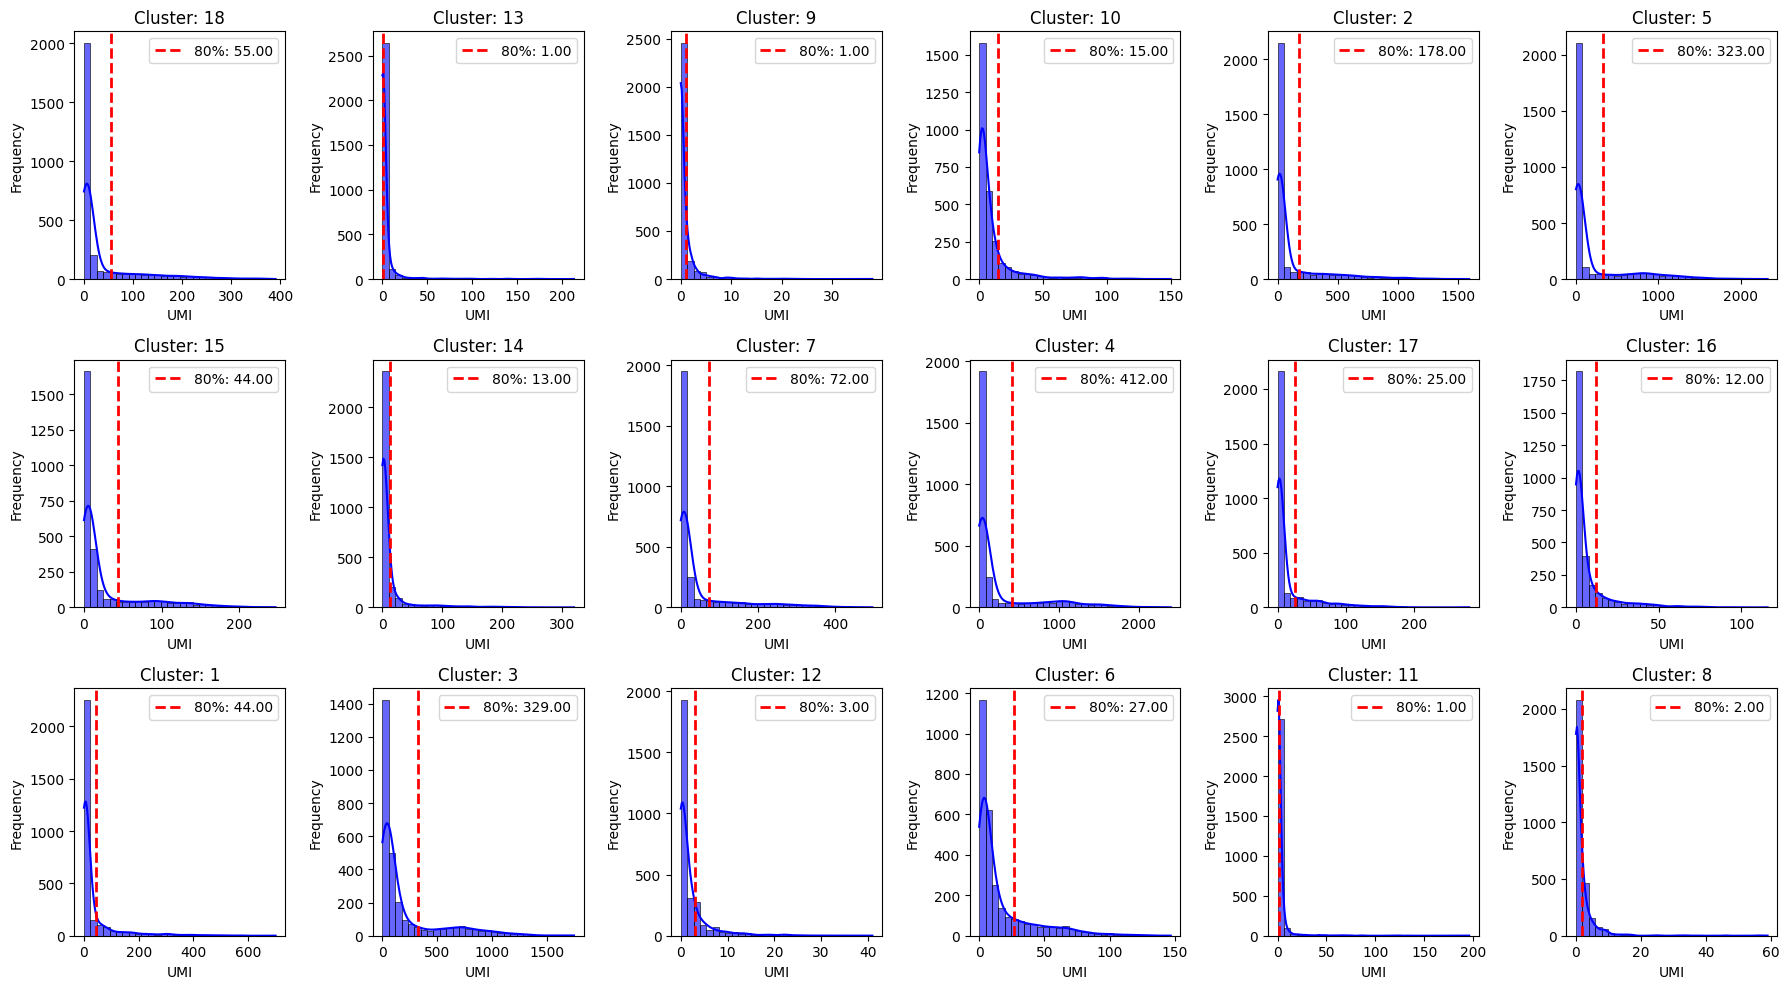

In [13]:
# Plot histograms with percentile threshold lines
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(df_numeric.columns):
    ax = axes[i]
    sns.histplot(df_numeric[col], bins=30, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
    ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"80%: {thresholds[col]:.2f}")
    ax.set_title(f"Cluster: {col}")
    ax.set_xlabel("UMI")
    ax.set_ylabel("Frequency")
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [14]:
# thresholds_df.T

In [15]:
# # UMI Th should be placed directly afther the main distrubution or inbetween the two in case of a bi-modal distribution

# updated_th = [25.0,57.0,422.0,25.0,11.0,25.0,17.0,9.0,34.0,50.0,75.0,50.0,34.0,120.0,440.0,548.0,210.0,250.0]

# keys = list(thresholds.keys())

# for k, v in zip(keys, updated_th):
#     thresholds[k] = v

# thresholds_df = pd.DataFrame.from_dict(thresholds, orient="index", columns=["UMI Th"])

# # Plot histograms with 99th percentile threshold lines
# fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 10))
# axes = axes.flatten()

# for i, col in enumerate(df_numeric.columns):
#     ax = axes[i]
#     sns.histplot(df_numeric[col], bins=30, kde=True, color="blue", edgecolor="black", alpha=0.6, ax=ax)
#     ax.axvline(thresholds[col], color="red", linestyle="dashed", linewidth=2, label=f"Th: {thresholds[col]:.2f}")
#     ax.set_title(f"Cluster: {col}")
#     ax.set_xlabel("UMI")
#     ax.set_ylabel("Frequency")
#     ax.legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [16]:
# Calculate putative cell count per spot 
# by replacing the values less than the percentile threshold with 0, counting medians, and dividing by them
thresholds_broadcasted = thresholds_df.reindex(deconvolution.index).values 

deconvolution_filtered = deconvolution.where(deconvolution >= thresholds_broadcasted, 0)

deconvolution_nonzero = deconvolution_filtered.replace(0, np.nan)

cluster_medians = deconvolution_nonzero.median(axis=1, numeric_only=True)

cell_count = np.ceil(deconvolution_nonzero.div(cluster_medians, axis=0))

cell_count = cell_count.fillna(0).astype(int)

cell_count.T.sum()

Cluster
18     883
13    5868
9     2558
10     834
2      894
5      889
15     867
14    1106
7      851
4      887
17     894
16     850
1      924
3      873
12    1213
6      913
11    4346
8     1586
dtype: int64

In [17]:
cells_per_spot = 10 # Set putative meadian cell per spot count
spots = deconvolution.shape[1]

print(f'                       The predicted total cell number is {spots * cells_per_spot}')
print(f'The total cell number observed after the deconvolution is {cell_count.T.sum().sum()}')
print(f'                                The ratio is {(spots * cells_per_spot)/(cell_count.T.sum().sum())}')

                       The predicted total cell number is 28980
The total cell number observed after the deconvolution is 27236
                                The ratio is 1.0640328976354825


In [18]:
# Call Putative cell clusters per spot

# Convert Visium and cell_count to dense format
Visium = Visium.astype(float)
cell_count = cell_count.astype(float)

# Create a new DataFrame for subcells
filtered_columns = [
    f"{spot}_{cluster}" for spot in Visium.columns for cluster in df_clusters.index
    if cell_count.at[cluster, spot] > 0  # Only keep clusters with nonzero putative cell counts
]

# Initialize putative_cell_df with only the required columns
putative_cell_df = pd.DataFrame(0, index=Visium.index, columns=filtered_columns, dtype=float)

# Populate putative_cell_df with gene expression values
for spot in Visium.columns:
    for cluster, genes in df_clusters["Genes"].items():
        if cell_count.at[cluster, spot] > 0:  # Check if putative cell count is above 0
            subspot_name = f"{spot}_{cluster}"  
            putative_cell_df[subspot_name] = Visium[spot]  # Copy UMI cell values
            putative_cell_df.loc[~putative_cell_df.index.isin(genes), subspot_name] = 0  # Set non-cluster genes to 0

putative_cell_per_spot = putative_cell_df.astype(int)

putative_cell_per_spot

,AACAGGAAGAGCATAG-1_9,AACAGGATTCATAGTT-1_13,AACAGGATTCATAGTT-1_12,AACAGGTTCACCGAAG-1_13,AACAGGTTCACCGAAG-1_12,AACAGGTTCACCGAAG-1_11,AACAGTCAGGCTCCGC-1_9,AACATACTCATATGCG-1_11,AACATACTCATATGCG-1_8,AACATAGTCTATCTAC-1_13,...,TGTTGGCCAGACCTAC-1_14,TGTTGGCCAGACCTAC-1_7,TGTTGGCCAGACCTAC-1_4,TGTTGGCCAGACCTAC-1_17,TGTTGGCCAGACCTAC-1_16,TGTTGGCCAGACCTAC-1_1,TGTTGGCCAGACCTAC-1_3,TGTTGGCCAGACCTAC-1_12,TGTTGGCCAGACCTAC-1_6,TGTTGGCCAGACCTAC-1_11
Gene,,,,,,,,,,,,,,,,,,,,,
Rrs1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sulf1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jph1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kcnq5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Col9a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tspyl2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Map7d2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nhs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Call Putative cells per spot

cell_count.index = cell_count.index.astype(str)
cell_count.columns = cell_count.columns.astype(str)

# Initialize a new DataFrame for putative_cells
putative_cell_data = {}

# Iterate through each subcell in putative_cell_per_spot
for subcell in putative_cell_per_spot.columns:
    cell, cluster = map(str, subcell.split("_"))  # Ensure names are strings
    
    # Check if cluster and cell exist in cell_count before accessing
    if cluster in cell_count.index and cell in cell_count.columns:
        putative_count = cell_count.at[cluster, cell]
    else:
        print(f"Warning: Skipping {subcell} - No match found in cell_count")
        continue  # Skip this subcell if the match isn't found

    if putative_count > 0:  # Only process if there are putative_cells
        putative_count = int(np.ceil(putative_count))  # Ensure it's an integer
        split_values = np.ceil(putative_cell_per_spot[subcell] / putative_count).astype(int)
    
        # Create new columns for each putative_cell
        for i in range(1, putative_count + 1):  # Now `putative_count` is an integer
            putative_cell_name = f"{subcell}_{i}"
            putative_cell_data[putative_cell_name] = split_values

# Convert to DataFrame
putative_cell_df = pd.DataFrame(putative_cell_data)

putative_cell_df = putative_cell_df.loc[:, putative_cell_df.sum(axis=0) != 0]

putative_cell_df = putative_cell_df.astype(str)

putative_cell_df = putative_cell_df[~putative_cell_df.index.duplicated(keep="first")]

putative_cell_df

,AACAGGAAGAGCATAG-1_9_1,AACAGGAAGAGCATAG-1_9_2,AACAGGAAGAGCATAG-1_9_3,AACAGGATTCATAGTT-1_13_1,AACAGGATTCATAGTT-1_13_2,AACAGGATTCATAGTT-1_13_3,AACAGGATTCATAGTT-1_13_4,AACAGGATTCATAGTT-1_13_5,AACAGGATTCATAGTT-1_13_6,AACAGGATTCATAGTT-1_13_7,...,TGTTGGCCAGACCTAC-1_3_1,TGTTGGCCAGACCTAC-1_3_2,TGTTGGCCAGACCTAC-1_12_1,TGTTGGCCAGACCTAC-1_12_2,TGTTGGCCAGACCTAC-1_12_3,TGTTGGCCAGACCTAC-1_12_4,TGTTGGCCAGACCTAC-1_12_5,TGTTGGCCAGACCTAC-1_6_1,TGTTGGCCAGACCTAC-1_6_2,TGTTGGCCAGACCTAC-1_11_1
Gene,,,,,,,,,,,,,,,,,,,,,
Rrs1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sulf1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jph1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kcnq5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Col9a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tspyl2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Map7d2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Nhs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Randomly allocate Putative cells within their spot

# Spot radius and min distance
SPOT_RADIUS = 15 # Pixels (15 pixels = 50µm)
MIN_DISTANCE = 6 # Minimum pixel separation between putative_cells (6 pixels = 20 µm = two cells)

# Initialize spatial coordinates dictionary
putative_cell_spatial = {}

# Iterate over putative_cells and assign random spatial positions
for putative_cell in putative_cell_df.columns:
    # Extract the correct `cell_cluster` name
    cell_cluster = putative_cell.split("_", 1)[0]  # Keep only barcode (remove extra numbers)

    if cell_cluster in tissue_positions_data.index:
        center_x = tissue_positions_data.at[cell_cluster, "pxl_row_in_fullres"]
        center_y = tissue_positions_data.at[cell_cluster, "pxl_col_in_fullres"]
    else:
        print(f"Warning: {cell_cluster} not found in tissue_positions_data")
        continue  # Skip if no spatial data

    # Generate unique positions within spot radius
    putative_cell_positions = []
    attempts = 0
    
    while len(putative_cell_positions) < 1:  # Only need one valid position per putative_cell
        # Randomly place within the spot's circular area
        rand_radius = np.random.uniform(0, SPOT_RADIUS)
        rand_angle = np.random.uniform(0, 2 * np.pi)
        new_x = center_x + rand_radius * np.cos(rand_angle)
        new_y = center_y + rand_radius * np.sin(rand_angle)
        
        # Ensure at least MIN_DISTANCE separation from other putative_cells
        if all(np.sqrt((new_x - x)**2 + (new_y - y)**2) >= MIN_DISTANCE for x, y in putative_cell_positions):
            putative_cell_positions.append((new_x, new_y))
            putative_cell_spatial[putative_cell] = (new_x, new_y)
        else:
            attempts += 1
            if attempts > 100:  # Prevent infinite loops
                print(f"Warning: Could not place {putative_cell} with required spacing")
                break

# Convert to mimic the Vizgen format
putative_cell_spatial_df = pd.DataFrame.from_dict(putative_cell_spatial, orient="index", columns=["center_x", "center_y"])
putative_cell_spatial_df['z'] = 0
putative_cell_spatial_df['fov'] = 0

# Export data in Vizgen format
putative_cell_df.astype(int).T.to_csv('cell_by_gene.csv') 
putative_cell_spatial_df.to_csv('cell_metadata.csv')

putative_cell_spatial_df

,center_x,center_y,z,fov
AACAGGAAGAGCATAG-1_9_1,2052.839691,337.205525,0,0
AACAGGAAGAGCATAG-1_9_2,2070.469274,328.850790,0,0
AACAGGAAGAGCATAG-1_9_3,2057.671420,328.548354,0,0
AACAGGATTCATAGTT-1_13_1,1684.969559,708.552857,0,0
AACAGGATTCATAGTT-1_13_2,1689.184480,718.496060,0,0
...,...,...,...,...
TGTTGGCCAGACCTAC-1_12_4,1673.345285,762.368032,0,0
TGTTGGCCAGACCTAC-1_12_5,1685.494830,760.957413,0,0
TGTTGGCCAGACCTAC-1_6_1,1688.904147,763.405320,0,0
TGTTGGCCAGACCTAC-1_6_2,1682.371364,753.364573,0,0


In [21]:
# Export Cluster numbers
cluster_df = putative_cell_spatial_df.index.str.extract(r'-1_(\d+)_')
cluster_df = cluster_df.rename(columns={0: 'Cluster'})
cluster_df.index = putative_cell_spatial_df.index
cluster_df.to_csv('cluster_info.csv')
cluster_df.head()

,Cluster
AACAGGAAGAGCATAG-1_9_1,9
AACAGGAAGAGCATAG-1_9_2,9
AACAGGAAGAGCATAG-1_9_3,9
AACAGGATTCATAGTT-1_13_1,13
AACAGGATTCATAGTT-1_13_2,13
